In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

## 1. Data generation

Create a function for generating the data. Both the input u (noisy stimulus) and the target output y (identity of the stimulus) are one-dimensional. The input now consist of a first stimulus, followed by a delay and the second stimulus

$
u(t) = 
\begin{cases}
u_1, & \text{if } 5 \le t \le 10 \\
u_2, & \text{if } 60 \le t \le 70 \\
0, & \text{otherwise}
\end{cases}
$ 

The two stimuli are defined as

$
u_i = \frac{1}{f_{max} - f_{min}} (f_i - \frac{f_{max} + f_{min}}{2}), i = 1,2
$ 

with $f_i$ sampled uniformly from the set {10, 14, 18, 22, 26, 30, 34}, and $f_{min} = 10, f_{max} = 34$ the smallest and largest elements of that set. The target output y is the normalized difference between the stimuli:

$
y = \frac{f_1 - f_2}{f_{max} - f_{min}}
$

Note that in the paper, they use random delays and more points fi. Discuss how that potentially affects the solution.



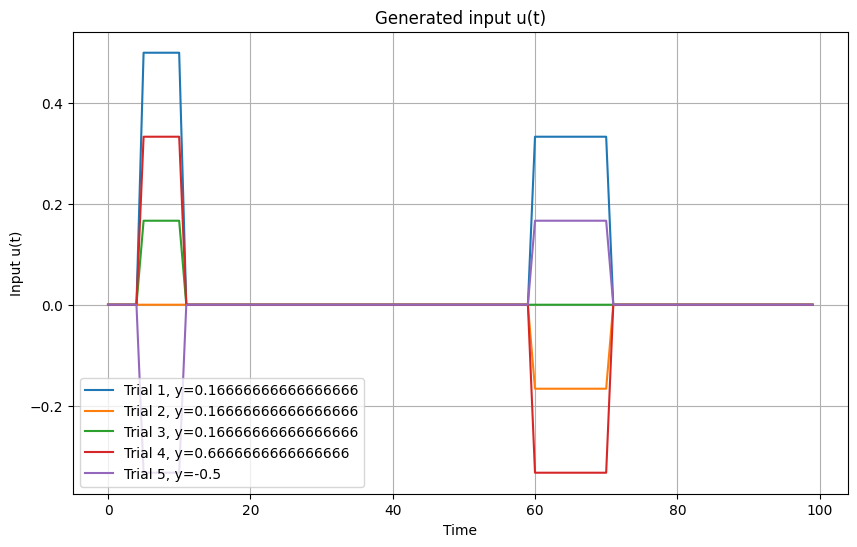

In [2]:
def compute_stimulus(fmin, fmax, f):
    u_i = 1/(fmax - fmin) * (f - (fmax + fmin)/2)
    return u_i


def create_input_data(time):
    u = np.zeros(len(time))
    possible_f = np.array([10, 14, 18, 22, 26, 30, 34])
    f_min = possible_f.min()
    f_max = possible_f.max()
    f_1 = np.random.choice(possible_f)
    f_2 = np.random.choice(possible_f)

    for idx, t_val in enumerate(time):
        if 5 <= t_val <= 10:
            u[idx] = compute_stimulus(f_min, f_max, f_1)
        elif 60 <= t_val <= 70:
            u[idx] = compute_stimulus(f_min, f_max, f_2)
        else:
            u[idx] = 0

    y = (f_1 - f_2) / (f_max - f_min)
    return u, y


def create_input_dataframe_multiple_trials(time, trials=100):
    data = []
    for _ in range(trials):
        u, y = create_input_data(time)
        data.append({'u': u, 'y': y})
    df = pd.DataFrame(data)
    return df

t = np.arange(0, 100)
input = create_input_dataframe_multiple_trials(t, trials=5)


plt.figure(figsize=(10, 6))
for i in range(len(input)):
    plt.plot(t, input['u'][i], label=f'Trial {i+1}, y={input["y"][i]}')
plt.xlabel('Time')
plt.ylabel('Input u(t)')
plt.title('Generated input u(t)')
plt.legend()
plt.grid(True)
plt.show()


## 2. Recurrent Neural Network Initialization

Extend your network implementation to allow for recurrent connectivity of arbitrary rank.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim 

# RNN Model of arbitary rank
class RNNModel(nn.Module): 
    def __init__(self, N, rank):
        super(RNNModel, self).__init__()
        self.N = N
        self.rank = rank
        self.m = nn.Parameter(torch.randn(rank, N))
        self.n = nn.Parameter(torch.randn(rank, N))
        self.I = torch.randn(N)
        self.w = torch.randn(N) * 4  
        self.tau = 100
        self.dt = 20

    def forward(self, u_batch):
        B, T = u_batch.shape
        x = torch.zeros(B, self.N, device=u_batch.device)  # per batch initialization
        z_out = []
        x_traj = [] 

        for t in range(T):
            u_t = u_batch[:, t]  # (B,)
            phi_x = torch.tanh(x)  # (B, N)
            J_phi = (1 / self.N) * (phi_x @ self.n.T) @ self.m
            dx = (-x + J_phi + u_t.unsqueeze(1) * self.I) * (self.dt / self.tau)
            x = x + dx
            z_t = (phi_x @ self.w) / self.N  
            z_out.append(z_t)
            x_traj.append(x)
        x_traj = torch.stack(x_traj, dim=1)  
        z_out = torch.stack(z_out, dim=1)  # (B, T)
        return x_traj, z_out


## 3. Training the network

Train a network of size N = 128 and rank R = 2 by minimizing the mean squared error between the target and the network output during the last 5 time steps of each trial. The loss should drop below 5e-3. If it does not, make sure to visualize your data and the networks output, and try debugging the network using the tips from exercise 1. 


Step 0, Loss: 0.2054
Step 100, Loss: 0.1316
Step 200, Loss: 0.1006
Step 300, Loss: 0.1296
Step 400, Loss: 0.1050
Step 500, Loss: 0.1326
Step 600, Loss: 0.1364
Step 700, Loss: 0.1200
Step 800, Loss: 0.1271
Step 900, Loss: 0.1185
Step 1000, Loss: 0.1134
Step 1100, Loss: 0.1069
Step 1200, Loss: 0.1209
Step 1300, Loss: 0.1340
Step 1400, Loss: 0.1656
Step 1500, Loss: 0.1172
Step 1600, Loss: 0.0951
Step 1700, Loss: 0.0217
Step 1800, Loss: 0.0107
Step 1900, Loss: 0.0079
Training stopped at step 1913 with loss 0.0047


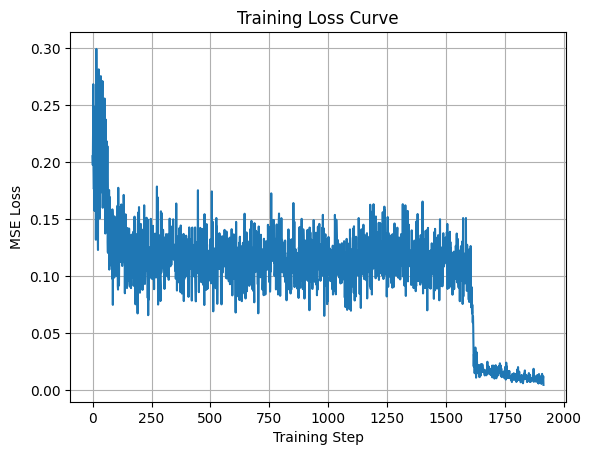

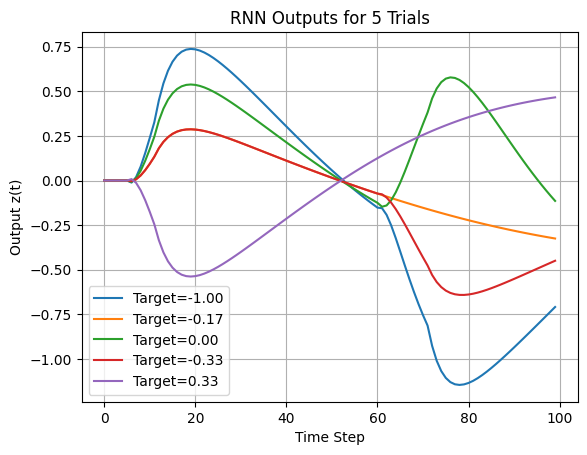

In [8]:
# Settings
N = 128
stop_loss = 5e-3
max_steps = 5_000 
R = 2

batch_size = 32
lr = 5e-3
T_total = 100
T_eval = 5


def get_batch(time, batch_size):
    df = create_input_dataframe_multiple_trials(time, trials=batch_size)
    u = np.stack(df['u'].values)  
    y = np.array(df['y'].values)  
    return torch.tensor(u, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


model = RNNModel(N=N, rank=R)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

losses = []
step = 0
while True:
    u_batch, y_batch = get_batch(np.arange(T_total), batch_size)
    _, z = model(u_batch)
    z_decision = z[:, -T_eval:]
    y_exp = y_batch.unsqueeze(1).expand_as(z_decision)
    loss = loss_fn(z_decision, y_exp)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    losses.append(loss.item())

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")
    
    if loss.item() < stop_loss or step >= max_steps:
        print(f"Training stopped at step {step} with loss {loss.item():.4f}")
        break

    step += 1

# Plot loss
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# Visualize network outputs
with torch.no_grad():
    u_batch, y_batch = get_batch(np.arange(T_total), batch_size=5)
    x, z = model(u_batch)
    for i in range(5):
        plt.plot(z[i].numpy(), label=f"Target={y_batch[i]:.2f}")
    plt.title("RNN Outputs for 5 Trials")
    plt.xlabel("Time Step")
    plt.ylabel("Output z(t)")
    plt.legend()
    plt.grid(True)
    plt.show()

## 4. Connectivity

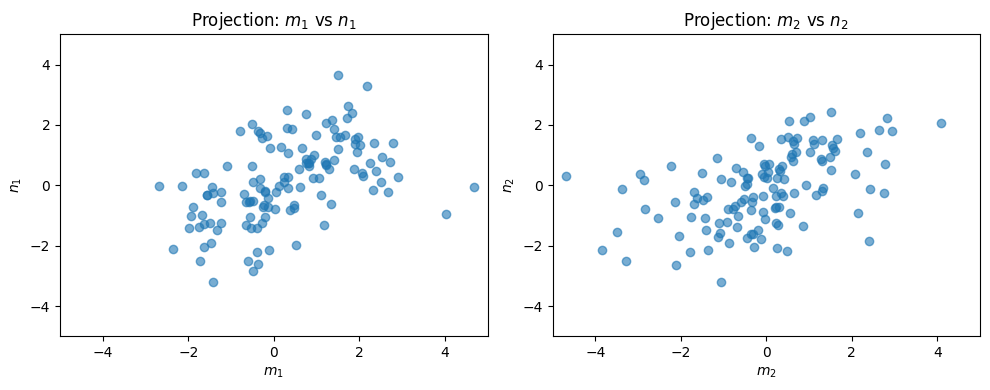

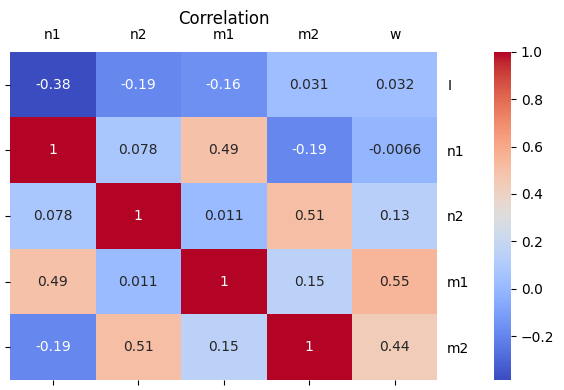

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_connectivity_patterns(model):
    m = model.m.detach().cpu().numpy() 
    n = model.n.detach().cpu().numpy()  
    w = model.w.detach().cpu().numpy() 
    I = model.I.detach().cpu().numpy()

    # Projections: scatter m_i vs n_i (for each mode)
    m1, m2 = m[0], m[1]
    n1, n2 = n[0], n[1]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(m1, n1, alpha=0.6)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel(r"$m_1$")
    plt.ylabel(r"$n_1$")
    plt.title(r"Projection: $m_1$ vs $n_1$")

    plt.subplot(1, 2, 2)
    plt.scatter(m2, n2, alpha=0.6)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel(r"$m_2$")
    plt.ylabel(r"$n_2$")
    plt.title(r"Projection: $m_2$ vs $n_2$")
    plt.tight_layout()
    plt.show()

    # Correlation coefficients of patterns 
    patterns = np.stack([I, n[0], n[1], m[0], m[1], w], axis=0)
    labels = ['I', 'n1', 'n2', 'm1', 'm2', 'w']
    cov = np.corrcoef(patterns)

    row_idxs = [0, 1, 2, 3, 4]  # I, n1, n2, m1, m2
    col_idxs = [1, 2, 3, 4, 5]  # n1, n2, m1, m2, w
    cov_sub = cov[np.ix_(row_idxs, col_idxs)]
    row_labels = ['I', 'n1', 'n2', 'm1', 'm2']
    col_labels = ['n1', 'n2', 'm1', 'm2', 'w']

    # Plot
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    sns.heatmap(cov_sub, annot=True, cmap='coolwarm',
                xticklabels=col_labels, yticklabels=row_labels,
                cbar_kws={"pad": 0.1})
    
    # Format: move labels to right/top
    ax.tick_params(
        labelleft=False, labelbottom=False,
        labelright=True, labeltop=True, rotation=0
    )
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('right')
    plt.title("Correlation", pad=20)
    plt.tight_layout()
    plt.show()

plot_connectivity_patterns(model)

## 5. Activity

Project the N-dimensional activity onto the m1,m2, to obtain latent variables κ1,κ2. Is their activity showing the two time scales you might expect from the connectivity patterns?

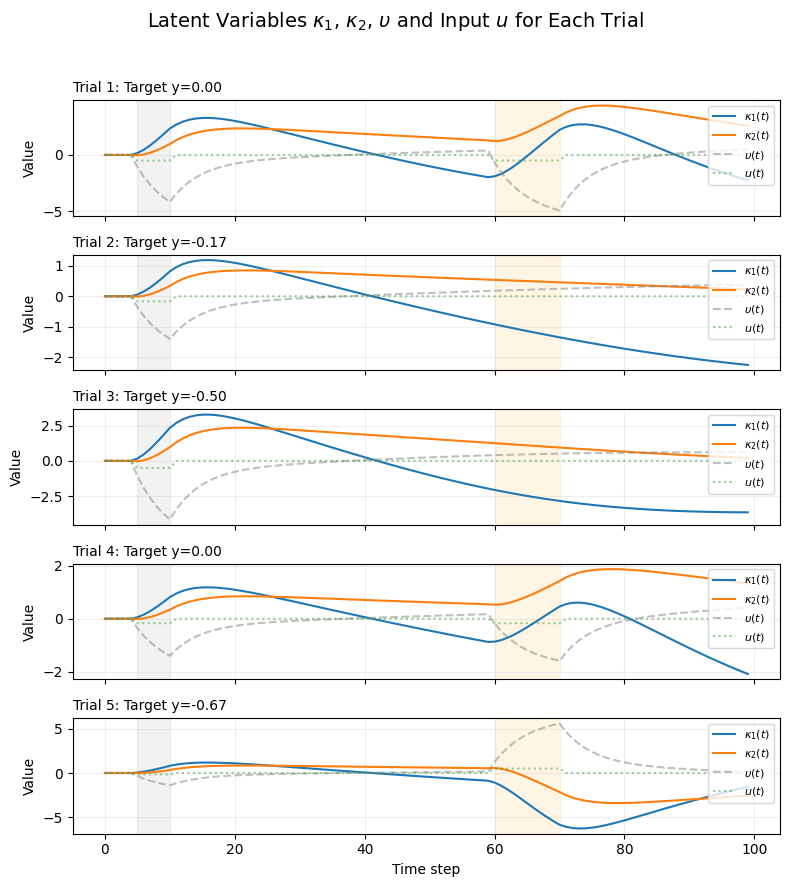

In [27]:
def project_activity_on_m(model, x):
    """
    Projects the activity x onto the connectivity patterns m and n.
    Returns two latent variables kappa1 and kappa2.
    """
    m = model.m.detach().cpu().numpy()
    I = model.I.detach().cpu().numpy()
    
    # Project activity onto m and n
    kappa1 = (x @ m[0].T) / np.linalg.norm(m[0])
    kappa2 = (x @ m[1].T) / np.linalg.norm(m[1])
    v = (x @ I.T) / np.linalg.norm(I)
    return kappa1, kappa2, v

def plot_kappa_trials(kappa1, kappa2, v, u, time=None, subtitles=None, suptitle=None):
    n_trials = kappa1.shape[0]
    T = kappa1.shape[1]
    if time is None:
        time = np.arange(T)
    fig, axes = plt.subplots(n_trials, 1, figsize=(8, 1.8 * n_trials), sharex=True)
    if n_trials == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.plot(time, kappa1[i], label=r'$\kappa_1(t)$', color='C0')
        ax.plot(time, kappa2[i], label=r'$\kappa_2(t)$', color='C1')
        ax.plot(time, v[i], label=r'$\upsilon(t)$', color='gray', alpha=0.5, linestyle='--')
        ax.plot(time, u[i], label=r'$u(t)$', color='C2', alpha=0.5, linestyle=':')
        ax.axvspan(5, 10, color='gray', alpha=0.10)
        ax.axvspan(60, 70, color='orange', alpha=0.10)
        ax.set_ylabel("Value")
        if subtitles is not None and i < len(subtitles):
            ax.set_title(subtitles[i], fontsize=10, loc='left')
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.2)
    if suptitle:
        fig.suptitle(suptitle, fontsize=14)
    axes[-1].set_xlabel("Time step")
    plt.tight_layout(rect=[0, 0, 1, 0.96] if suptitle else None)
    plt.show()

# Example usage:
with torch.no_grad():
    u_batch, y_batch = get_batch(np.arange(T_total), batch_size=5)
    x, z = model(u_batch)
kappa1, kappa2, v = project_activity_on_m(model, x)
u_np = u_batch.numpy()
wise_comments = [
    f"Trial {i+1}: Target y={y_batch[i].item():.2f}" for i in range(len(y_batch))
]

plot_kappa_trials(
    kappa1, kappa2, v, u_np,
    time=np.arange(T_total),
    subtitles=wise_comments,
    suptitle=r"Latent Variables $\kappa_1$, $\kappa_2$, $\upsilon$ and Input $u$ for Each Trial"
)


Fast dynamics - $\kappa_1$ rising quickly during stimulus 1, decaying after - suggest a transient integration mode.

Slow drift between stimuli - $\kappa_2$ - reflect longer memory time scales, possibly along a nearly line attractor or integrator axis.

## 6. Connectivity - Guassian approximation 

Test if the covariance patterns characterize the network connectivity by fitting and resampling a 6-dimensional Gaussian to the connectivity patterns.

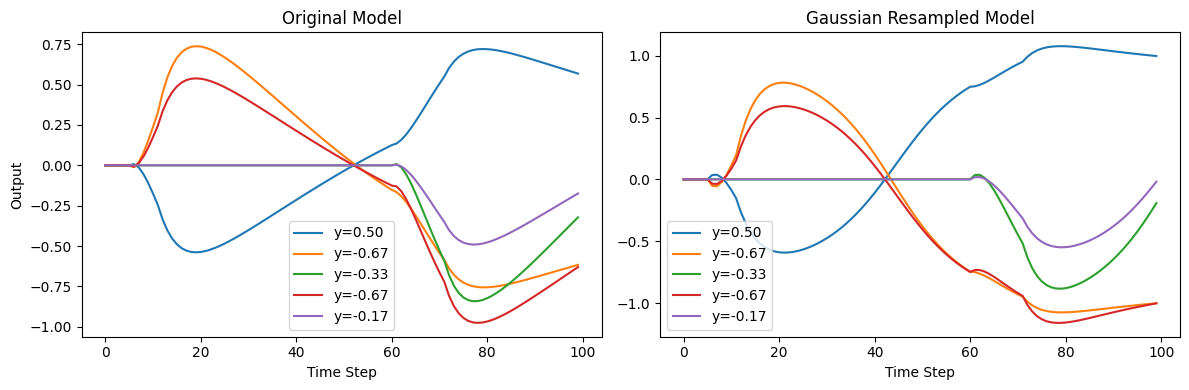

In [15]:
import copy

def resample_model_from_gaussian(model):
    m = model.m.detach().cpu().numpy()
    n = model.n.detach().cpu().numpy()
    I = model.I.detach().cpu().numpy()
    w = model.w.detach().cpu().numpy()
    patterns = np.stack([I, n[0], n[1], m[0], m[1], w], axis=0)
    patterns_T = patterns.T  # (N, 6)
    mean = np.mean(patterns_T, axis=0)
    cov = np.cov(patterns_T, rowvar=False)
    synthetic = np.random.multivariate_normal(mean, cov, size=patterns_T.shape[0]).T  # (6, N)
    I_new, n1_new, n2_new, m1_new, m2_new, w_new = synthetic

    model_gauss = copy.deepcopy(model)
    with torch.no_grad():
        model_gauss.I.copy_(torch.tensor(I_new, dtype=model.I.dtype))
        model_gauss.n[0].copy_(torch.tensor(n1_new, dtype=model.n.dtype))
        model_gauss.n[1].copy_(torch.tensor(n2_new, dtype=model.n.dtype))
        model_gauss.m[0].copy_(torch.tensor(m1_new, dtype=model.m.dtype))
        model_gauss.m[1].copy_(torch.tensor(m2_new, dtype=model.m.dtype))
        model_gauss.w.copy_(torch.tensor(w_new, dtype=model.w.dtype))
    return model_gauss

# Get a fresh batch of data
u_batch, y_batch = get_batch(np.arange(T_total), batch_size=5)

# Run both models on the same input
with torch.no_grad():
    x, z = model(u_batch)
    model_gauss = resample_model_from_gaussian(model)
    x_gauss, z_gauss = model_gauss(u_batch)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Original model: all trials in one plot
for i in range(5):
    axes[0].plot(z[i].numpy(), label=f"y={y_batch[i]:.2f}")
axes[0].set_title("Original Model")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Output")
axes[0].legend()

# Gaussian-resampled model: all trials in one plot
for i in range(5):
    axes[1].plot(z_gauss[i].numpy(), label=f"y={y_batch[i]:.2f}")
axes[1].set_title("Gaussian Resampled Model")
axes[1].set_xlabel("Time Step")
axes[1].legend()

plt.tight_layout()
plt.show()


## 7. equivalent circuit

Under the appropriate assumptions, the trained network can now be described by a two-dimensional equivalent circuit. Its dynamics are given by

$
\frac{d \kappa_1}{dt} = - \kappa_1 + \tilde{\sigma_{m1n1}} \kappa_1 + \tilde{\sigma_{n1I}}v(t) \\
\frac{d \kappa_2}{dt} = - \kappa_2 + \tilde{\sigma_{m2n2}} \kappa_2 + \tilde{\sigma_{n2I}}v(t) \\
$

The coupling terms again encapsulate the system’s nonlinearity, here via the scaling

$
\Delta = \sqrt{\sigma_{m1}^2 \kappa_1^2 + \sigma_{m2}^2 \kappa_2^2 + \sigma_I^2v^2}
$

Simulate the effective circuit for different inputs v. 

The circuit should perform qualitatively, but not necessarily quantitatively, the same as the full network. If it does not, try using the covariances reported in the paper: 
$\sigma_{n1m1} = 1, \sigma_{n2m2} = 0.5, \sigma_{n1I} = 0.5, \sigma_{n2I} = 1.9, \sigma_{m1w} = 2.8, \sigma_{m2w} = −2.2$

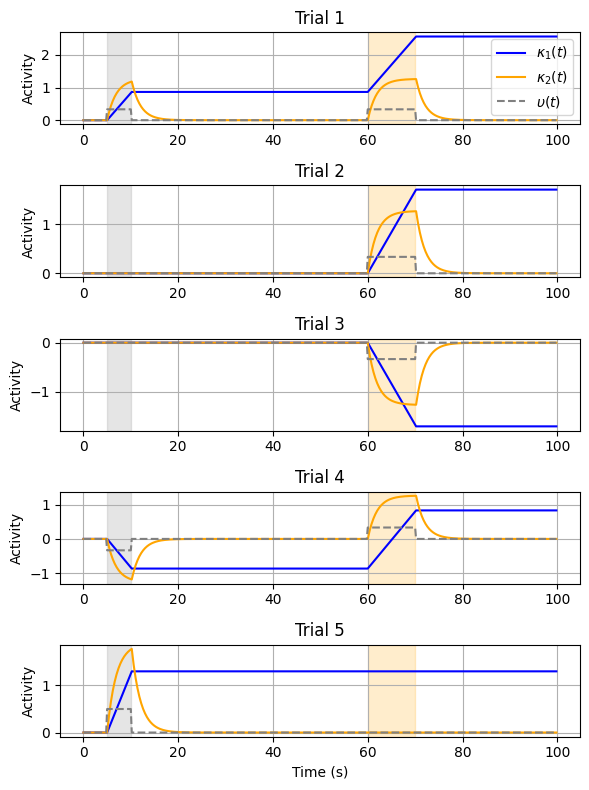

In [29]:

T = 100
dt = 0.2
time = np.arange(0, T, dt)

def simulate_equivalent_circuit(time, input_func=None,
                                sigma_mn=(1.0, 0.5), sigma_nI=(0.5, 1.9)):

    steps = len(time)
    kappa1 = np.zeros(steps)
    kappa2 = np.zeros(steps)
    v = np.zeros(steps) if input_func is None else input_func(np.arange(steps))

    for t in range(1, steps):
        dk1 = (-kappa1[t-1] + sigma_mn[0] * kappa1[t-1] + sigma_nI[0] * v[t-1]) * dt
        dk2 = (-kappa2[t-1] + sigma_mn[1] * kappa2[t-1] + sigma_nI[1] * v[t-1]) * dt
        kappa1[t] = kappa1[t-1] + dk1
        kappa2[t] = kappa2[t-1] + dk2

    return kappa1, kappa2, v
    # Show 5 trials of the equivalent circuit with different inputs

plt.figure(figsize=(6, 8))
for i in range(5):
    example_input = create_input_data(time)[0]
    k1, k2, v = simulate_equivalent_circuit(
        time,
        input_func=lambda t_idx, inp=example_input: inp
    )
    plt.subplot(5, 1, i+1)
    plt.plot(time, k1, label=r'$\kappa_1(t)$', color='blue')
    plt.plot(time, k2, label=r'$\kappa_2(t)$', color='orange')
    plt.plot(time, v, label=r'$\upsilon(t)$', linestyle='dashed', color='gray')
    plt.axvspan(5, 10, color='gray', alpha=0.2)
    plt.axvspan(60, 70, color='orange', alpha=0.2)
    plt.ylabel("Activity")
    plt.title(f"Trial {i+1}")
    if i == 0:
        plt.legend(loc='upper right')
    plt.grid(True)
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()